In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
print(X_footsteps_continuous_absolute.shape)
print(Y_footsteps_continuous_absolute.shape)

(762, 26)
(762, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FR is swinging
idxs = np.where(X_footsteps_continuous_absolute[:, -2] == 0)[0]
X_footsteps_continuous_absolute_FR_swinging = X_footsteps_continuous_absolute[idxs]
Y_footsteps_continuous_absolute_FR_swinging = Y_footsteps_continuous_absolute[idxs]

In [8]:
print("Percentage of footstep where FR and RL are swinging: ", len(idxs)/len(X_footsteps_continuous_absolute) * 100)

Percentage of footstep where FR and RL are swinging:  50.0


## Predict FR foot -> x

In [9]:
X_footsteps_continuous_absolute_FR_swinging[0, :]

array([ 1.00000000e-01,  0.00000000e+00,  0.00000000e+00,  8.09653828e-02,
       -2.02463898e-03,  1.59138117e-03, -1.23841927e-01,  3.95024138e-02,
       -7.59827570e-04,  2.28621442e-01,  1.21625062e-01, -3.79108766e-01,
        2.46642183e-01, -1.31444720e-01, -3.79176914e-01, -2.63236963e-01,
        1.38137159e-01, -3.79106102e-01, -2.95698084e-01, -1.24579731e-01,
       -3.79040156e-01,  1.00000000e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.00000000e+00])

In [10]:
Y_footsteps_continuous_absolute_FR_swinging[0, :]

array([ 0.04600682,  0.0010881 ,  0.04629837, -0.00111264])

### Linear Regression

In [11]:
# Input
X = np.hstack((X_footsteps_continuous_absolute_FR_swinging[:, :3], # motion command
               X_footsteps_continuous_absolute_FR_swinging[:, 3:9], # velocity command
               X_footsteps_continuous_absolute_FR_swinging[:, 9:11], # FL (x,y) position
               X_footsteps_continuous_absolute_FR_swinging[:, 12:14], # FR (x,y) position
               X_footsteps_continuous_absolute_FR_swinging[:, 15:17], # RL (x,y) position
               X_footsteps_continuous_absolute_FR_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_footsteps_continuous_absolute_FR_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_relative_swinging_x = LinearRegression()

# Fit the model
model_fr_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9989795312909475
RMSE:  0.0026677956880701583
The lowest error is:  6.947768224138673e-05
The highest error is:  0.012799947969432235
The avg. error is:  0.0016670088731402615


In [12]:
model_fr_relative_swinging_x.coef_

array([[ 4.97343902e-01, -1.38777878e-17,  2.28983499e-15,
        -1.24073681e-01,  2.90118785e-01, -1.05602205e-02,
        -8.97296529e-03, -4.72003835e-02,  3.47662885e-02,
        -5.45472422e-01,  1.70020839e-01, -2.04010614e-04,
        -1.02523809e+00,  3.98169676e-02, -2.70022079e-01,
        -2.03553872e-01,  4.79959324e-01]])

In [13]:
model_fr_relative_swinging_x.intercept_

array([0.02518138])

Text(0, 0.5, 'Predictions')

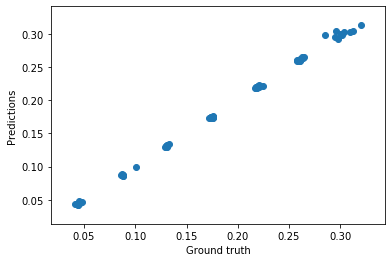

In [15]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [16]:
#%store model_fr_relative_swinging_x

In [17]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [18]:
# Save model
#joblib.dump(model_fr_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fr_relative_swinging_x.sav")

### Predict FR foot -> y

In [19]:
# Input
X = np.hstack((X_footsteps_continuous_absolute_FR_swinging[:, :3], # motion command
               X_footsteps_continuous_absolute_FR_swinging[:, 3:9], # velocity command
               X_footsteps_continuous_absolute_FR_swinging[:, 9:11], # FL (x,y) position
               X_footsteps_continuous_absolute_FR_swinging[:, 12:14], # FR (x,y) position
               X_footsteps_continuous_absolute_FR_swinging[:, 15:17], # RL (x,y) position
               X_footsteps_continuous_absolute_FR_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_footsteps_continuous_absolute_FR_swinging[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_relative_swinging_y = LinearRegression()

# Fit the model
model_fr_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.6826680812591663
RMSE:  0.0010705546915630736
The lowest error is:  6.501088325006066e-06
The highest error is:  0.0033617253270299616
The avg. error is:  0.0008197933580021299


In [20]:
model_fr_relative_swinging_y.coef_

array([[ 2.09617936e-02,  5.20417043e-17,  8.15320034e-17,
         3.20989860e-03,  2.17560574e-01, -4.11348209e-03,
        -8.82133705e-05, -5.48490775e-03, -1.31482667e-02,
         5.13376350e-02, -2.20422339e-01, -1.83947834e-01,
        -1.88093587e-01, -1.29180915e-01, -2.58520793e-01,
         4.12889659e-02, -1.03953257e-01]])

In [21]:
model_fr_relative_swinging_y.intercept_

array([0.03465639])

Text(0, 0.5, 'Predictions')

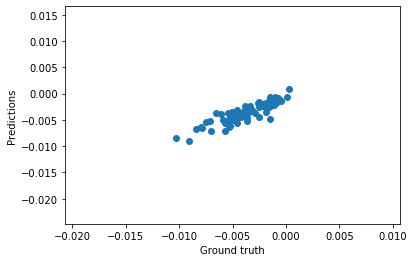

In [22]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [23]:
#%store model_fr_relative_swinging_y

In [24]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [25]:
# Save model
#joblib.dump(model_fr_relative_swinging_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fr_relative_swinging_y.sav")